## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
# using Piccolo
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using LaTeXStrings
using TrajectoryIndexingUtils
using SparseArrays
using Statistics
using CairoMakie
using Random
using NamedTrajectories

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Piccolissimo
│  └─ QuantumCollocation
└ @ Base.Precompilation precompilation.jl:651
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `QuantumCollocation.ProblemTemplates.UnitaryUniversalProblem :: Union{}` in module `QuantumCollocation.ProblemTemplates`
└ @ Base.Docs docs/Docs.jl:243


In [57]:
# Problem parameters
T = 40
Δt = 0.8
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
seeds = rand(1:1000, 25)
F=0.9999
num_iter = 6000
hess = false
hess_iter = 120
Qs = 10 .^ range(-4.0, 1.0, length=25)
a_bound = 1.0
dda_bound = 0.5
R=5e-3

0.005

In [46]:

Qs[end]

1.4677992676220695

In [59]:
using JLD2, FileIO
using CairoMakie
using Statistics

# Directories where data is saved
var_dir = "artifacts/var_gap_data_export"
tog_dir = "artifacts/tog_gap_data_export"

# Load the first seed file to get metadata
var_first = load(joinpath(var_dir, "var_probs_seed_idx_1.jld2"))
tog_first = load(joinpath(tog_dir, "htog_probs_seed_idx_1.jld2"))

# Extract common parameters
# Qs = var_first["Qs"]

n_seeds = length(readdir(var_dir)) - 1  # Subtract 1 for plot.png

# Initialize arrays to store loaded data
var_probs = Matrix{Any}(undef, n_seeds, length(Qs))
htog_probs = Matrix{Any}(undef, n_seeds, length(Qs))

# Load all var_probs data
for i in 1:n_seeds
    data = load(joinpath(var_dir, "var_probs_seed_idx_$(i).jld2"))
    var_probs[i, :] = data["var_probs"]
end

# Load all htog_probs data
for i in 1:n_seeds
    data = load(joinpath(tog_dir, "htog_probs_seed_idx_$(i).jld2"))
    htog_probs[i, :] = data["htog_probs"]
end

println("Loaded data for $(n_seeds) seeds across $(length(Qs)) Q values")

Loaded data for 25 seeds across 25 Q values


In [5]:
# Qs = Qs[1:end-4]
# var_probs = var_probs[:, 1:end-4]
# tog_probs = htog_probs[:, 1:end-4]

In [6]:
# Adjoint, rollout initialization

∂ₑHₐ = [PAULIS.Z]
varsys_add = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)
n_seeds = length(seeds)
nQ = length(Qs)

25

In [7]:
typeof(var_probs[end,end].trajectory.:Ũ⃗)#.Δt[1], var_prob[1].trajectory.Δt[end ÷ 2]

SubArray{Float64, 2, Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Vector{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}}, true}, Tuple{}}, Tuple{UnitRange{Int64}, Base.Slice{Base.OneTo{Int64}}}, false}

In [8]:
∂ₑH = [PAULIS.Z]
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.Z]

function var_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}}, 
    H_errors::Vector{Matrix{ComplexF64}}
)
    Δt = traj.Δt[1]
    varsys = VariationalQuantumSystem(H_drives, H_errors)
    Ũ⃗, ∂Ũ⃗ = variational_unitary_rollout(traj, varsys)

    U = iso_vec_to_operator(Ũ⃗[:, end])
    # First error term
    ∂U = iso_vec_to_operator(∂Ũ⃗[1][:, end])

    d = size(U, 1)
    return abs(tr((U'*∂U)'*(U'*∂U))) / (T * Δt)^2 / d
end

# J_var = var_obj(var_prob.trajectory, H_drives, error_ops)

var_obj (generic function with 1 method)

In [9]:
function tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64}
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))
    
    # Toggle integral
    H_ti = sum(Δt[i] .* U[i]' * H_error * U[i] for i=1:T-1)

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end


tog_obj (generic function with 1 method)

In [10]:
function commutator(A::AbstractMatrix{<:Number}, B::AbstractMatrix{<:Number})
    return A*B - B*A
end

commutator (generic function with 1 method)

In [11]:
function pert_tog_obj(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    order::Int=1,
    a_bound::Float64=a_bound
)
    T = traj.T
    Δt = get_timesteps(traj)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(traj, sys)))

    # toggle integral
    H_ti = zeros(ComplexF64, size(U[1]))

    # note: U_1 = I, so U[:, k] = U_{k-1}.
    # you need to go to T-1, only
    for k in 1:T-1
        Hₖ = sum(traj.a[l, k] / a_bound * H for (l, H) in enumerate(H_drives))
        adjⁿH_E = H_error
        Eₖ_n = H_error * Δt[k]
        
        # get the different orders of the Hadamard lemma
        for n in 2:order
            coef_n = ComplexF64(im^(n-1) * a_bound^(n-1) * Δt[k]^n / factorial(big(n)))
            adjⁿH_E = commutator(Hₖ, adjⁿH_E)
            # Eₖ_n = push!(Eₖ_n, coef_n * adjⁿH_E)
            Eₖ_n += coef_n * adjⁿH_E
        end

        # nth order toggle integral up to k
        H_ti += U[k]' * Eₖ_n * U[k]
    end

    d₁ = size(U[1], 1)
    Δt₁ = Δt[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

pert_tog_obj (generic function with 1 method)

In [12]:
"""
    upsample_constant(vals, dts; factor=2)

Take control values `vals` with time steps `dts` (same length),
and upsample by `factor`, returning (vals_up, dts_up).
"""
function upsample_constant_controls(vals::AbstractArray; factor::Int=2)
    vals_up = repeat(vals, inner=factor)
    return vals_up
end

# Example
vals = [1, 2, 3]
dts  = [0.2, 0.2, 0.2]

vals_up = upsample_constant_controls(vals; factor=3)

println(vals_up)  # [1, 1, 2, 2, 3, 3]
#println(dts_up) 
function upsample_matrix(controls::AbstractArray, dts::AbstractArray; factor::Int=2)
    new_controls = []
    for c in eachrow(controls)
        new_c = upsample_constant_controls(c; factor=factor)
        T = length(c)
        push!(new_controls, new_c)
    end
    dts_up = dts[1] / factor .* ones(length(dts) * factor*T)
    new_controls = reduce(vcat, [v' for v in new_controls])
    return new_controls, dts_up
end
function tog_obj_upsample(
    traj::NamedTrajectory, 
    H_drives::Vector{Matrix{ComplexF64}},
    H_error::Matrix{ComplexF64};
    factor::Int=1,
    t_cut::Int=traj.T,
)
    T = traj.T * factor
    controls = traj[1:t_cut].a
    a_new, Δt_new = upsample_matrix(traj.a, traj.Δt; factor=factor)

    sys = QuantumSystem(H_drives)
    U = iso_vec_to_operator.(eachcol(unitary_rollout(a_new, Δt_new, sys)))
    
    # Toggle integral (truncate at (traj.T - 1) * factor)
    H_ti = sum(Δt_new[i] .* U[i]' * H_error * U[i] for i = 1:(traj.T - 1) * factor)

    d₁ = size(U[1], 1)
    Δt₁ = Δt_new[1]
    metric = norm(tr(H_ti'H_ti)) / (T * Δt₁)^2 / d₁
    return metric
end

[1, 1, 1, 2, 2, 2, 3, 3, 3]


tog_obj_upsample (generic function with 1 method)

In [13]:
# display(CairoMakie.plot(var_probs[end, end].trajectory, [:Ũ⃗, :a, :da, :dda]))
# display(CairoMakie.plot(htog_probs[end, end].trajectory, [:Ũ⃗, :a, :da, :dda]))


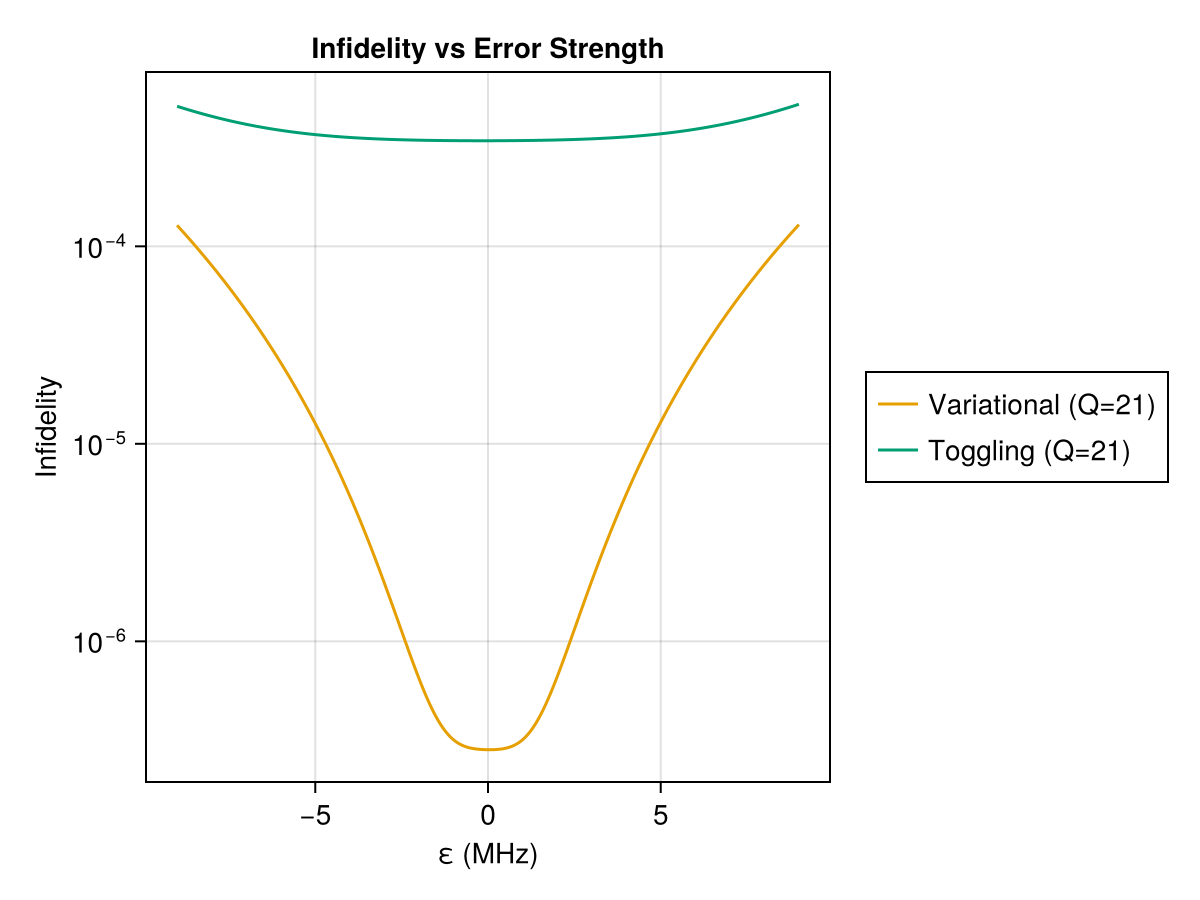

In [50]:
# Define epsilon values to sweep
epsilons = -0.009:0.00002:0.009

# Initialize arrays to store fidelities
Q = 21
# Calculate fidelities for each Q value and epsilon

# Arrays to store fidelities across seeds for this Q

var_fidelities = []
tog_fidelities = []
# Calculate fidelities for variational case
for (eps_idx, eps) in enumerate(epsilons)
    var_fids = []
    tog_fids = []
    for seed_idx in 1:n_seeds
        var_prob = var_probs[seed_idx, Q]
        htog_prob = htog_probs[seed_idx, Q]
        
        # Create perturbed system with additive error
        H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
        perturbed_sys = QuantumSystem(eps*PAULIS.Z,H_drive)
        
        # Calculate fidelity for variational trajectoryunitary_rollout_fidelity
        push!(var_fids, unitary_rollout_fidelity(
            var_prob.trajectory, 
            perturbed_sys
        ))
        # Calculate fidelity for toggling trajectory
        push!(tog_fids, unitary_rollout_fidelity(
            htog_prob.trajectory, 
            perturbed_sys
        ))
    end
    push!(var_fidelities, mean(var_fids))
    push!(tog_fidelities, mean(tog_fids))
end
    
# 

mhz_eps = 1000 .* epsilons

# Create the plot
f = Figure()
ax = Axis(f[1, 1],
    yscale=log10,
    xlabel="ε (MHz)", 
    ylabel="Infidelity",
    title="Infidelity vs Error Strength",
)

colors = Makie.wong_colors()

# Plot lines for different Q values (showing a subset for clarity)
# Q_indices_to_plot = [1, 5, 10, 15, 20, 25]  # Adjust as needed

# Variational
lines!(ax, mhz_eps, 1 .- var_fidelities, 
    label="Variational (Q=$Q)", 
    color=colors[2], 
    linestyle=:solid)

# Toggling
lines!(ax, mhz_eps, 1 .- tog_fidelities, 
    label="Toggling (Q=$Q)", 
    color=colors[3], 
    linestyle=:solid)

Legend(f[1, 2], ax, position=:lb)

f

# Save the figure
# save(joinpath(var_dir, "fidelity_vs_epsilon.png"), f)


Searching for optimal seeds across Q indices 15-25...

Q_idx = 16, Q = 0.1333521432163324
  New best var_obj: seed=1, var_obj=1.5923779500735352e-5
  New best tog_obj: seed=1, var_obj=1.4476004417877276e-5
  New best diff: seed=1, tog_obj=1.4476004417877276e-5, var_obj=1.4476004417877276e-5, diff=0.00032864175097140763
  New best var_obj: seed=2, var_obj=1.4602232900644188e-5
  New best diff: seed=2, tog_obj=1.4476006179881654e-5, var_obj=1.4476006179881654e-5, diff=0.00032996275030599474
  New best var_obj: seed=4, var_obj=1.4148038565455534e-5
  New best diff: seed=4, tog_obj=1.4476007457805378e-5, var_obj=1.4476007457805378e-5, diff=0.000330416601164006
  New best tog_obj: seed=5, var_obj=1.4476030413350625e-5
  New best var_obj: seed=12, var_obj=1.2003952886638339e-5
  New best diff: seed=12, tog_obj=1.4476010481567278e-5, var_obj=1.4476010481567278e-5, diff=0.00033256101603952495
  New best var_obj: seed=13, var_obj=9.486482137284243e-6
  New best tog_obj: seed=13, var_obj=1.4476

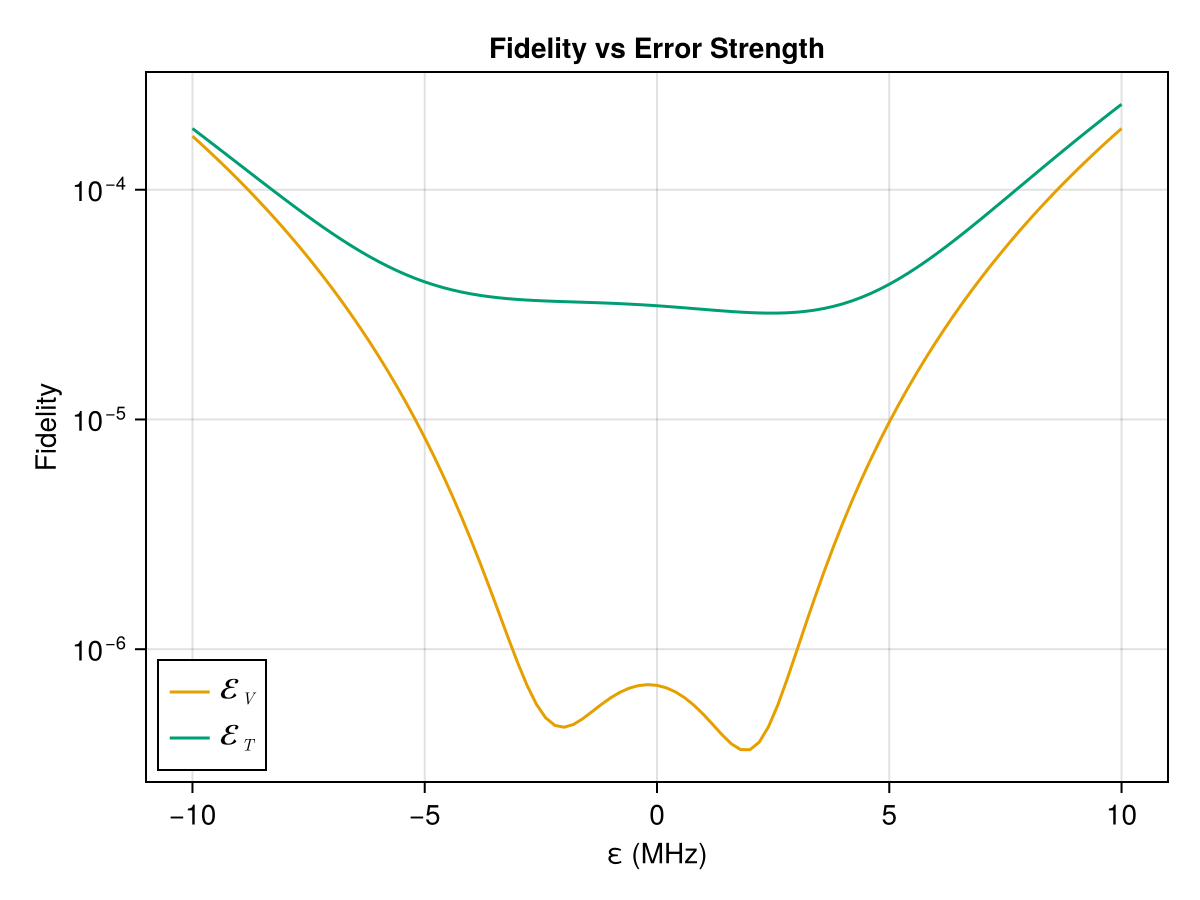

In [72]:
# ============================================================================
# FIND OPTIMAL SEEDS
# ============================================================================

# Define H_drives and H_errors for objective calculations
H_drives = [PAULIS.X, PAULIS.Y, PAULIS.Z]
error_ops = [PAULIS.Z]  # Assuming single error operator

# Track best seeds across Q_idx from 15 to 21
min_var_seed = nothing
min_var_Q_idx = nothing
min_var_obj_value = Inf

max_tog_seed = nothing
max_tog_Q_idx = nothing
max_tog_obj_value = -Inf

best_seed = nothing
best_Q_idx = nothing
max_diff = -Inf

println("\nSearching for optimal seeds across Q indices 15-25...")

for Q_idx in 16:25
    println("\nQ_idx = $Q_idx, Q = $(Qs[Q_idx])")
    
    for seed_idx in 1:n_seeds
        var_prob = var_probs[seed_idx, Q_idx]
        htog_prob = htog_probs[seed_idx, Q_idx]
        var_fidelity = unitary_rollout_fidelity(var_prob.trajectory, sys)
        tog_fidelity = unitary_rollout_fidelity(htog_prob.trajectory, sys)
        if var_fidelity < 0.9999 || tog_fidelity < 0.9999
            continue
        end

        if !isnothing(var_prob) && !isnothing(htog_prob)
            # Calculate var_obj for this seed
            v_obj = var_obj(var_prob.trajectory, H_drives, error_ops)
            
            # Calculate tog_obj for this seed
            h_t_obj = tog_obj(htog_prob.trajectory, H_drives, PAULIS.Z)
            h_v_obj = var_obj(htog_prob.trajectory, H_drives, error_ops)
            
            # Check if this is the minimum var_obj
            if v_obj < min_var_obj_value
                min_var_obj_value = v_obj
                min_var_seed = seed_idx
                min_var_Q_idx = Q_idx
                println("  New best var_obj: seed=$seed_idx, var_obj=$v_obj")
            end

             # Check if this is the minimum var_obj
             if h_v_obj > max_tog_obj_value
                max_tog_obj_value = h_v_obj
                max_tog_seed = seed_idx
                max_tog_Q_idx = Q_idx
                println("  New best tog_obj: seed=$seed_idx, var_obj=$h_t_obj")
            end
            
            # Check if this is the maximum difference (tog_obj - var_obj)
            diff = abs(h_v_obj - v_obj)
            if diff > max_diff
                max_diff = diff
                best_seed = seed_idx
                best_Q_idx = Q_idx
                println("  New best diff: seed=$seed_idx, tog_obj=$h_t_obj, var_obj=$h_t_obj, diff=$diff")
            end
        end
    end
end

println("\n" * "="^70)
println("OPTIMAL SEEDS FOUND:")
println("="^70)
println("Minimum var_obj:")
println("  Seed index: $min_var_seed")
println("  Q index: $min_var_Q_idx")
println("  Q value: $(Qs[min_var_Q_idx])")
println("  var_obj value: $min_var_obj_value")
println("\nMax tog_obj:")
println("  Seed index: $max_tog_seed")
println("  Q index: $max_tog_Q_idx")
println("  Q value: $(Qs[max_tog_Q_idx])")
println("  var_obj value: $max_tog_obj_value")
println("\nMaximum difference (var_obj(tog_prob) - var_obj):")
println("  Seed index: $best_seed")
println("  Q index: $best_Q_idx")
println("  Q value: $(Qs[best_Q_idx])")
println("  Maximum difference: $max_diff")
println("="^70)

# Use the best var seed for plotting
Q_idx = best_Q_idx
best_var = var_probs[best_seed, best_Q_idx]
best_tog = htog_probs[best_seed, best_Q_idx]

# ============================================================================
# PLOTTING (using best var seed)
# ============================================================================

epsilons = -0.01:0.0002:0.01
script_tog = latexstring("\\mathcal{E}_{T}")
script_var = latexstring("\\mathcal{E}_{V}")

Q_ex = Qs[Q_idx]
Q_val = round(Q_ex, digits=5)

mhz_eps = 1000 .* epsilons
var_fidelities = []
tog_fidelities = []

# Calculate fidelities for variational case
for (eps_idx, eps) in enumerate(epsilons)
    # Create perturbed system with additive error
    H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
    perturbed_sys = QuantumSystem(eps*PAULIS.Z, H_drive)
    
    # Calculate fidelity for variational trajectory
    push!(var_fidelities, unitary_rollout_fidelity(
        best_var.trajectory, 
        perturbed_sys
    ))
    # Calculate fidelity for toggling trajectory
    push!(tog_fidelities, unitary_rollout_fidelity(
        best_tog.trajectory, 
        perturbed_sys
    ))
end


# Create the plot
f = Figure()
ax = Axis(f[1, 1],
    yscale=log10,
    xlabel="ε (MHz)", 
    ylabel="Fidelity",
    title="Fidelity vs Error Strength",
)

colors = Makie.wong_colors()

# Variational
lines!(ax, mhz_eps, 1 .- var_fidelities, 
    label=script_var, 
    color=colors[2], 
    linestyle=:solid)

# Toggling
lines!(ax, mhz_eps, 1 .- tog_fidelities, 
    label=script_tog, 
    color=colors[3], 
    linestyle=:solid)

# Place the legend INSIDE the axis at the bottom-left
axislegend(ax, position=:lb)

f

# Save the figure
# save(joinpath(var_dir, "fidelity_vs_epsilon.png"), f)

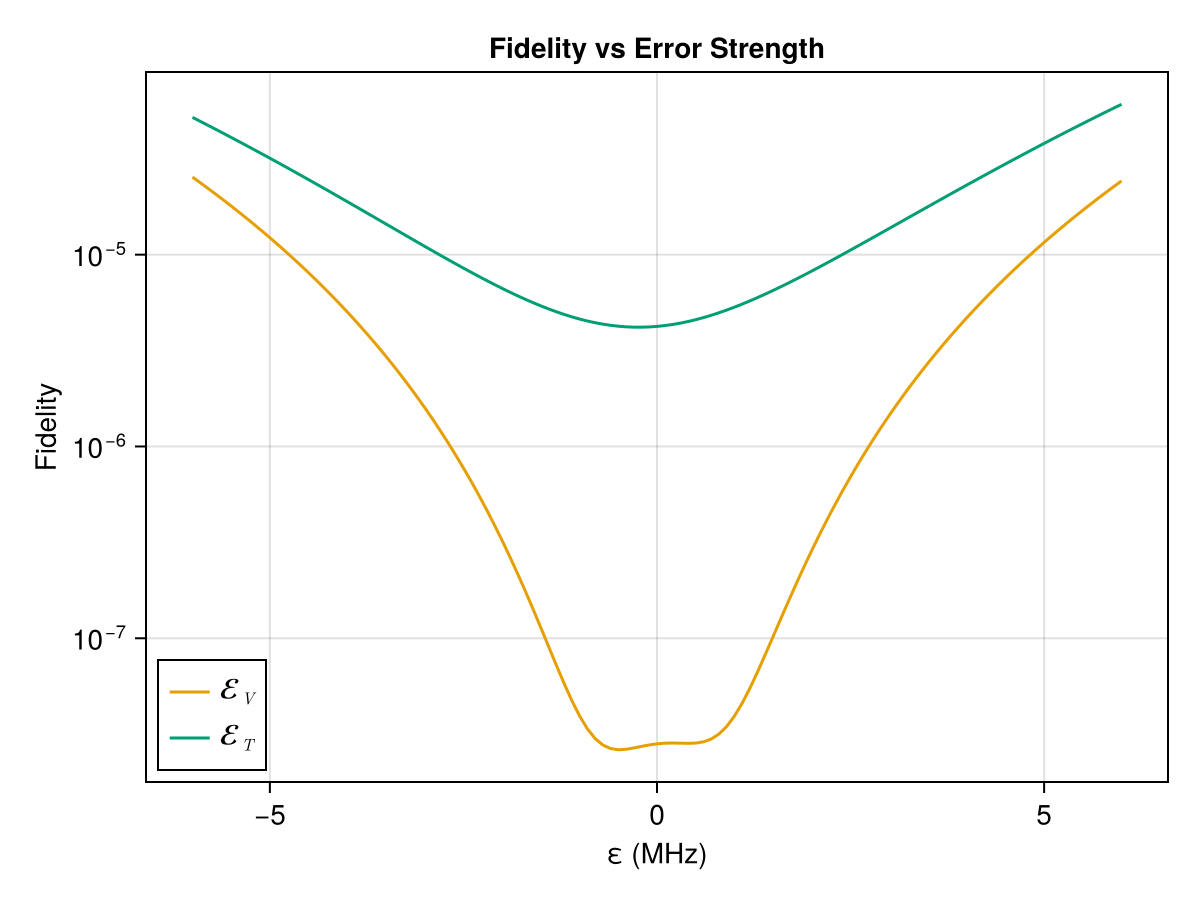

In [65]:
best_var = var_probs[5, 21]
best_tog = htog_probs[5, 21]

# ============================================================================
# PLOTTING (using best var seed)
# ============================================================================

epsilons = -0.006:0.0001:0.006
script_tog = latexstring("\\mathcal{E}_{T}")
script_var = latexstring("\\mathcal{E}_{V}")

Q_ex = Qs[Q_idx]
Q_val = round(Q_ex, digits=5)

mhz_eps = 1000 .* epsilons
var_fidelities = []
tog_fidelities = []

# Calculate fidelities for variational case
for (eps_idx, eps) in enumerate(epsilons)
    # Create perturbed system with additive error
    H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
    perturbed_sys = QuantumSystem(eps*PAULIS.Z, H_drive)
    
    # Calculate fidelity for variational trajectory
    push!(var_fidelities, unitary_rollout_fidelity(
        best_var.trajectory, 
        perturbed_sys
    ))
    # Calculate fidelity for toggling trajectory
    push!(tog_fidelities, unitary_rollout_fidelity(
        best_tog.trajectory, 
        perturbed_sys
    ))
end


# Create the plot
f = Figure()
ax = Axis(f[1, 1],
    yscale=log10,
    xlabel="ε (MHz)", 
    ylabel="Fidelity",
    title="Fidelity vs Error Strength",
)

colors = Makie.wong_colors()

# Variational
lines!(ax, mhz_eps, 1 .- var_fidelities, 
    label=script_var, 
    color=colors[2], 
    linestyle=:solid)

# Toggling
lines!(ax, mhz_eps, 1 .- tog_fidelities, 
    label=script_tog, 
    color=colors[3], 
    linestyle=:solid)

# Place the legend INSIDE the axis at the bottom-left
axislegend(ax, position=:lb)

f
